# **Analiza delovno aktivnega prebivalstva in BDP Slovenije**

### Podatki

*[Delovno aktivno prebivalstvo](https://podatki.gov.si/dataset/surs0700992s)*

*[Izdatkovna struktura BDP](https://podatki.gov.si/dataset/surs0301935s?resource_id=8935a064-5888-4ab9-9066-0838f6f2743b)*

In [ ]:
from pyaxis import pyaxis
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np

px_data = pyaxis.parse("./podatki/prebivalstvo.PX", encoding="windows-1250")
data = pd.DataFrame(px_data['DATA'])
data_slovenia = data[data['STATISTIČNA REGIJA'] == 'SLOVENIJA']
data['YEAR'] = data['MESEC'].str[:4]
data['DATA'] = pd.to_numeric(data['DATA'], errors='coerce')
data = data[data['YEAR'] != data['YEAR'].max()] # Izloči zadnje leto

px_data2 = pyaxis.parse("./podatki/bdp.PX", encoding="windows-1250")
data_bpd = pd.DataFrame(px_data2['DATA'])
data_bpd['DATA'] = pd.to_numeric(data_bpd['DATA'], errors='coerce')
data_bpd = data_bpd[data_bpd['LETO'] != data_bpd['LETO'].max()] # Izloči zadnje leto

Za lažjo primerjavo podatkov smo izbločili zadnje (trenutno) leto iz podatkov.

## Delovno prebivalstvo v Sloveniji

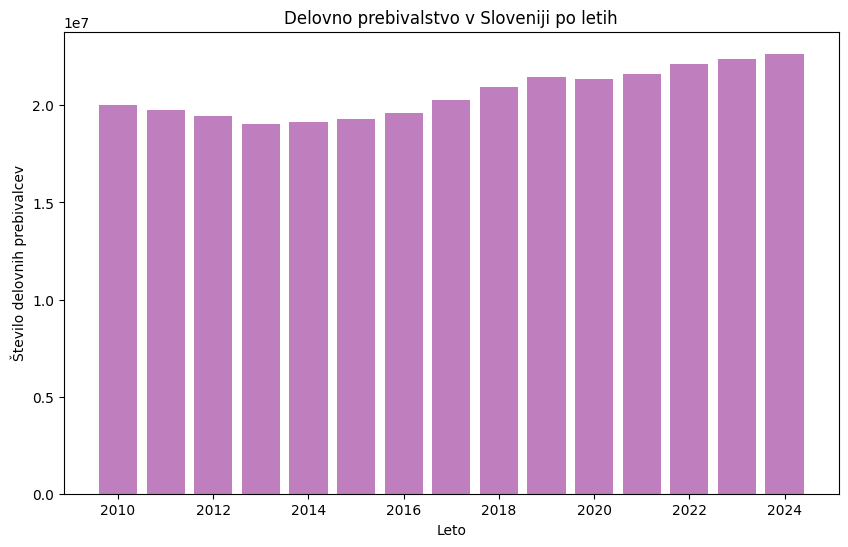

In [80]:
yearly_data = data.groupby('YEAR')['DATA'].sum()
yearly_data.index = pd.to_numeric(yearly_data.index)

plt.figure(figsize=(10, 6))
plt.bar(yearly_data.index, yearly_data.values, color='purple', alpha=0.5)
plt.xlabel('Leto')
plt.ylabel('Število delovnih prebivalcev')
plt.title('Delovno prebivalstvo v Sloveniji po letih')
plt.show()

Graf prikazije, da se število aktivnega delavnega prebivalstva veča.

## Delovno prebivalstvo glede na starost

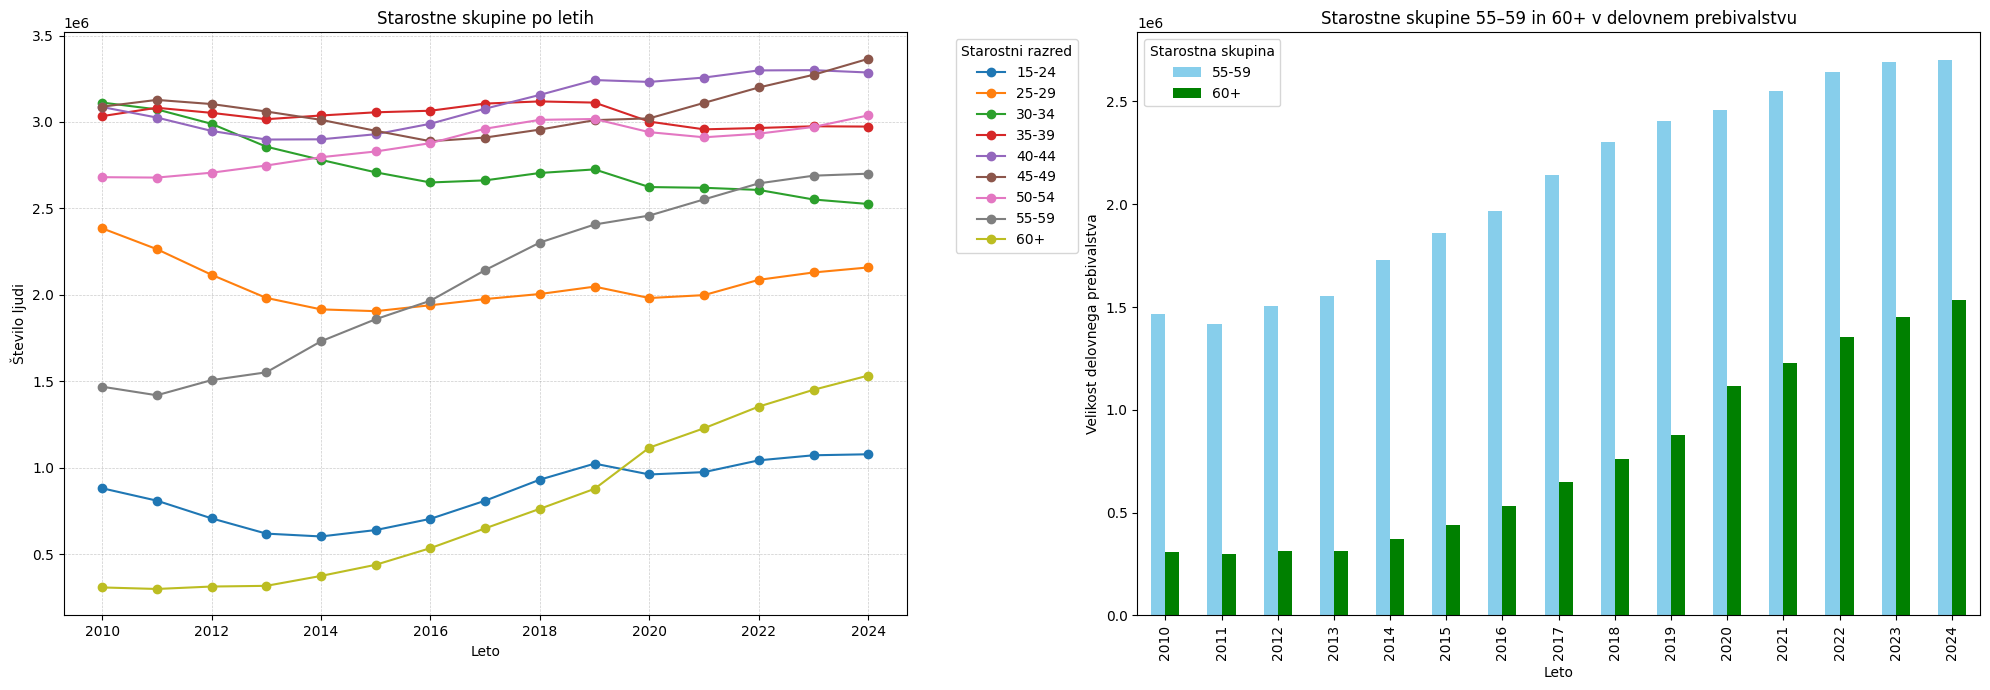

In [81]:
fig, axs = plt.subplots(1, 2, figsize=(20, 7))

# Črtni graf – vse starostne skupine
grouped = data.groupby(['YEAR', 'STAROSTNI RAZRED'])['DATA'].sum().unstack()
grouped.index = grouped.index.astype(int)
grouped = grouped.sort_index()

for age_group in grouped.columns:
    axs[0].plot(grouped.index, grouped[age_group], marker='o', label=age_group)

axs[0].set_xlabel('Leto')
axs[0].set_ylabel('Število ljudi')
axs[0].set_title('Starostne skupine po letih')
axs[0].legend(title='Starostni razred', bbox_to_anchor=(1.05, 1), loc='upper left')
axs[0].grid(True, color='gray', linestyle='--', linewidth=0.5, alpha=0.4)

# Stolpčni graf – samo skupini 55–59 in 60+
age_groups = data[data['STAROSTNI RAZRED'].isin(['55-59', '60+'])]
age_group_yearly_data = age_groups.groupby(['YEAR', 'STAROSTNI RAZRED'])['DATA'].sum().unstack()

age_group_yearly_data.plot(kind='bar', stacked=False, ax=axs[1], color=['skyblue', 'green'])
axs[1].set_xlabel('Leto')
axs[1].set_ylabel('Velikost delovnega prebivalstva')
axs[1].set_title('Starostne skupine 55–59 in 60+ v delovnem prebivalstvu')
axs[1].legend(title='Starostna skupina')

plt.tight_layout()
plt.show()

Iz levega grafa je razvidno, da je vse več ljudi, starejših od 50 let, delovno aktivnih. Eden od glavnih razlogov za to, je staranje prebivalstva in daljšanje življenske dobe.

Iz desnim grafom še bolj podrobno vidimo, da se ljudje vse kasneje upokojujejo, ker kasneje dosegajo pogoje za upokojitev. To je tudi posledica slabih pokojnin, ki si jih višajo s podaljševanjem delovne dobe.

## Struktura delovnega prebivalstva po regijah

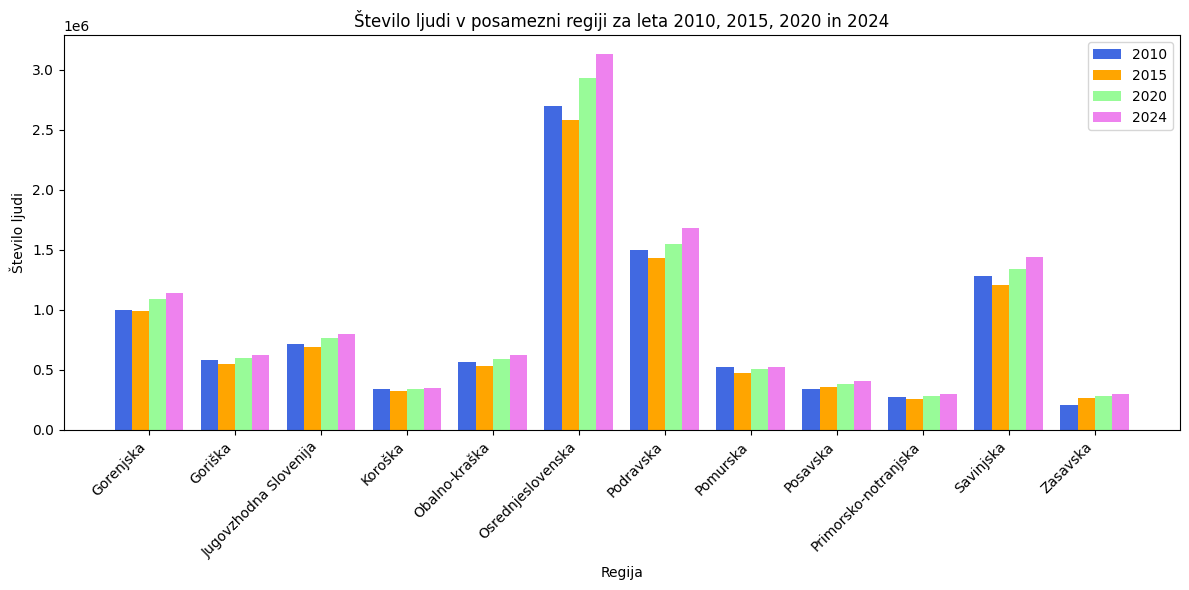

In [82]:
data_2010_regions = data[data['YEAR'] == '2010']
data_2015_regions = data[data['YEAR'] == '2015']
data_2020_regions = data[data['YEAR'] == '2020']
data_2024_regions = data[data['YEAR'] == '2024']

region_data_2010 = data_2010_regions[data_2010_regions['STATISTIČNA REGIJA'] != 'SLOVENIJA'].groupby('STATISTIČNA REGIJA')['DATA'].sum()
region_data_2015 = data_2015_regions[data_2015_regions['STATISTIČNA REGIJA'] != 'SLOVENIJA'].groupby('STATISTIČNA REGIJA')['DATA'].sum()
region_data_2020 = data_2020_regions[data_2020_regions['STATISTIČNA REGIJA'] != 'SLOVENIJA'].groupby('STATISTIČNA REGIJA')['DATA'].sum()
region_data_2024 = data_2024_regions[data_2024_regions['STATISTIČNA REGIJA'] != 'SLOVENIJA'].groupby('STATISTIČNA REGIJA')['DATA'].sum()

plt.figure(figsize=(12, 6))
bar_width = 0.2
x = np.arange(len(region_data_2010.index))

plt.bar(x - 1.5 * bar_width, region_data_2010.values, width=bar_width, color='royalblue', label='2010')
plt.bar(x - 0.5 * bar_width, region_data_2015.values, width=bar_width, color='orange', label='2015')
plt.bar(x + 0.5 * bar_width, region_data_2020.values, width=bar_width, color='palegreen', label='2020')
plt.bar(x + 1.5 * bar_width, region_data_2024.values, width=bar_width, color='violet', label='2024')

plt.xticks(x, region_data_2010.index, rotation=45, ha='right')
plt.xlabel('Regija')
plt.ylabel('Število ljudi')
plt.title('Število ljudi v posamezni regiji za leta 2010, 2015, 2020 in 2024')
plt.legend()
plt.tight_layout()
plt.show()

Najbolj izstopa Osrednjeslovenska regija, kar lahko povežemo s priseljevanjem v Ljubljano zaradi boljših pogojev in višjih plač. Največjo rast delovno aktivnega prebivalstva beležijo Osrednjeslovenska, Podravska in Savinjska regija, ki imajo tudi največja urbana središča. Koroška, Primorsko-notranjska in Posavska, kjer je rast delovno aktivnega prebivalstva počasnejša, predstavljajo manj urbanizirana območja Slovenije, ki predstvaljajo območja izseljevanja.

## Povezava med delovnim prebivalstvom in BDP

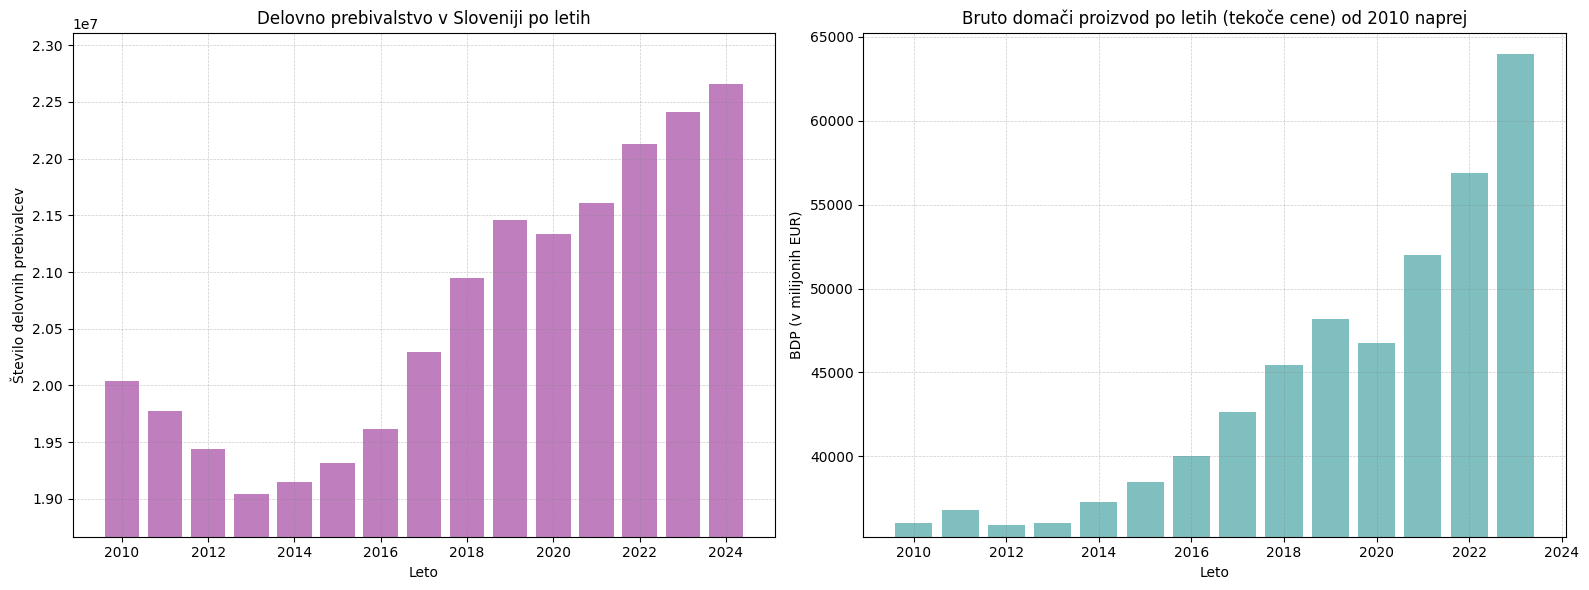

In [83]:
# Podatki o delovnem prebivalstvu
yearly_data = data.groupby('YEAR')['DATA'].sum()
yearly_data.index = pd.to_numeric(yearly_data.index)

# Podatki o BDP
bdp = data_bpd[
    (data_bpd['TRANSAKCIJE'] == 'Bruto domači proizvod') &
    (data_bpd['MERITVE'] == 'Tekoče cene (mio EUR)')
].copy()

bdp['LETO'] = bdp['LETO'].astype(int)
bdp = bdp[bdp['LETO'] >= 2010]
bdp = bdp.sort_values('LETO')

fig, axes = plt.subplots(1, 2, figsize=(16, 6))

# Prvi graf - Delovno prebivalstvo
axes[0].bar(yearly_data.index, yearly_data.values, color='purple', alpha=0.5)
axes[0].set_xlabel('Leto')
axes[0].set_ylabel('Število delovnih prebivalcev')
axes[0].set_title('Delovno prebivalstvo v Sloveniji po letih')
axes[0].grid(True, color='gray', linestyle='--', linewidth=0.5, alpha=0.4)
axes[0].set_ylim([yearly_data.min() * 0.98, yearly_data.max() * 1.02])


# Drugi graf - BDP
axes[1].bar(bdp['LETO'], bdp['DATA'],  color='teal', alpha=0.5)
axes[1].set_xlabel('Leto')
axes[1].set_ylabel('BDP (v milijonih EUR)')
axes[1].set_title('Bruto domači proizvod po letih (tekoče cene) od 2010 naprej')
axes[1].grid(True, color='gray', linestyle='--', linewidth=0.5, alpha=0.4)
axes[1].set_ylim([bdp['DATA'].min() * 0.98, bdp['DATA'].max() * 1.02])

# Prilagodite prikaz in prikazujte graf
plt.tight_layout()
plt.show()

Tukaj sem spremenila y skalo, da se bolje opazijo razlike v številu delovno aktivnega prebivalstva skozi leta.

In [84]:
# Primer podatkov
data_labor = pd.DataFrame({
    'LETO': list(range(2010, 2024)),
    'DATA': [850000, 860000, 855000, 858000, 860500, 863000, 870000, 872000, 875000, 877000, 880000, 885000, 888000, 890000]
})

data_bdp = pd.DataFrame({
    'LETO': list(range(2010, 2024)),
    'DATA': [35000, 36000, 37000, 37500, 38000, 39000, 40000, 40500, 41000, 41200, 41500, 41800, 42000, 42200]
})

merged = pd.merge(data_labor, data_bdp, on='LETO', suffixes=('_labor', '_bdp'))
correlation = merged['DATA_labor'].corr(merged['DATA_bdp'])
print(f"Korelacija med delovno aktivnim prebivalstvom in BDP: {correlation:.3f}")

Korelacija med delovno aktivnim prebivalstvom in BDP: 0.951


Korelacija med delovno aktivnim prebivalstvom in bruto domačim proizvodom (BDP), ki znaša 0.951, kaže na zelo močno pozitivno povezanost med tema dvema spremenljivkama. To pomeni, da se BDP praviloma povečuje, kadar se povečuje tudi število delovno aktivnih prebivalcev – in obratno. To potrjuje, da je BDP eden izmed ključnih dejavnikov gospodarske rasti.